<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 1  </H3>
<hr style="height:2px;border:none"/>

<h4 align='center'> Integrantes: Pablo Aguirre, Rol: 201473555-3; Jorge Aliste, Rol: 201473538-3 </h4>

## Pregunta 2

En este problema se trabajará con un dataset **HeartBeat Sounds** compuesto sonidos de latidos cardíacos en formato .wav. El objetivo es poder clasificar los sonidos en latidos cardíacos normales y anormales según las categorías incluidas.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron,LogisticRegression
from sklearn.decomposition import FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.io import wavfile

In [2]:
SAMPLE_RATE = 44100

def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name

def load_wav_file(name, path):
    s, b = wavfile.read(path + name)
    assert s == SAMPLE_RATE
    return b

def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux

> a) Construya un dataframe con los datos a analizar. Describa el dataset y determine cuántos registros hay
por clase.

In [3]:
df = pd.read_csv('./set_a.csv')

In [4]:
df.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


El dataset se compone de 4 atributos, los cuales son:
+ **dataset**: dataset al que pertenece el archivo de audio.
+ **fname**: nombre del archivo.
+ **label**: clasificación que se le dió al audio.
+ **sublabel**

In [5]:
df.shape

(176, 4)

El dataset contiene 176 registros, cada uno con 4 atributos.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
dataset     176 non-null object
fname       176 non-null object
label       124 non-null object
sublabel    0 non-null float64
dtypes: float64(1), object(3)
memory usage: 5.6+ KB


Del resumen del dataset, se puede observar que 52 registros tienen label nula. Estos corresponden a los audios que no estan clasificados y se trabajará con ellos más adelante.

In [7]:
df["label"].value_counts()

artifact    40
murmur      34
normal      31
extrahls    19
Name: label, dtype: int64

Inicialmente se tienen las siguientes clases con sus respectivas cantidades de registros:
+ **artifact**: 40 registros.
+ **murmur**: 34 registros.
+ **normal**: 31 registros.
+ **extrahls**: 19 registros.

> b) Lea los archivos *.wav* y transformelos en secuencias de tiempo. Realice un *padding* de ceros al final de cada secuencia para que todas queden representadas con la misma cantidad de elementos, explique la importancia de realizar este paso.

Realizar un padding de ceros antes de la transformada de Fourier discreta sirve para hacer una mejor interpolación de los puntos.

In [8]:
new_df =pd.DataFrame({'file_name' : df['fname'].apply(clean_filename,string='Aunlabelledtest'),
                     'target' : df['label'].fillna('unclassified')})


new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='./set_a/')
new_df['len_series'] = new_df['time_series'].apply(len)
new_df['time_series']=new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))

In [9]:
new_df.head()

,file_name,target,time_series,len_series
0,artifact__201012172012.wav,artifact,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900
1,artifact__201105040918.wav,artifact,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900
2,artifact__201105041959.wav,artifact,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900
3,artifact__201105051017.wav,artifact,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900
4,artifact__201105060108.wav,artifact,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900


In [10]:
new_df['target'].value_counts()

unclassified    52
artifact        40
murmur          34
normal          31
extrahls        19
Name: target, dtype: int64

A partir de lo anterior, se observa una nueva clase **unclassified** con 52 registros que proviene de los archivos .wav leidos y son los que tenían label nula anteriormente.

> c) Manipule los datos y cambie las etiquetas de los audios por otras asignadas por un doctor experto, el cual afirma que estos cambios son requeridos. Vuelva a determinar cuántos registros hay por clase. Nótese que ahora son 3 clases ¿Explique la problemática de tener etiquetas mal asignadas en los datos? ¿Un solo dato puede afectar esto?

In [11]:
new_labels = np.zeros((176,), dtype="int")

new_labels[:40] = 0
new_labels[18] = 0
new_labels[23] = 0

new_labels[40:59] = 1
for x in [40, 55]:
    new_labels[x] = 2

new_labels[59:93] = 2
for x in [62,63,65,68]:
    new_labels[x] = 1

new_labels[93:124] = 1
for x in [101, 107, 115, 116, 122]:
    new_labels[x] = 2

new_labels[124:]= [0,2,2,1,
                   1,1,1,1,
                   0,1,0,1,
                   1,1,2,1,
                   0,1,1,1,
                   1,1,2,0,
                   0,0,0,0,
                   0,0,1,0,
                   0,0,0,0,
                   0,1,0,2,
                   1,2,2,2,
                   2,2,2,2,
                   2,2,2,2] 

labels = ['artifact','normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels]

In [12]:
new_df['target'].value_counts()

normal/extrahls    65
artifact           58
murmur             53
Name: target, dtype: int64

Las nuevas clases son:
+ **normal/extrahls**: 65 registros.
+ **artifact**: 58 registros.
+ **murmur**: 53 registros.

Asignar las etiquetas de forma errónea puede causar un aumento del error de clasificación, sin embargo, si son pocos los datos que fueron mal etiquetados puede que no sea considerable.

> d) Codifique las distintas clases a valores numéricos para que puedan ser trabajados por los algoritmos
clasificadores.

In [13]:
new_df["target"] = new_df["target"].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes)

In [14]:
new_df["target"].value_counts()

2    65
0    58
1    53
Name: target, dtype: int64

 Como se aprecia, las clases fueron codificadas a valores numéricos, siendo 2 la clase **normal/extrahls**, 0 la clase **artifact** y 1 la clase **murmur**.

> e) Desordene los datos, evitando ası́ el orden en el que vienen la gran mayorı́a de las etiquetas. Cree la matriz que conforma a los datos en sus dimensiones sin preprocesar, es decir, cada ejemplo es una secuencia de amplitudes en el tiempo. ¿Las dimensiones de ésta indica que puede generar problemas? ¿De qué tipo?

In [15]:
new_df = new_df.sample(frac=1,random_state=44)
X = np.stack(new_df['time_series'].values, axis=0)
y = new_df.target.values
X.shape

(176, 396900)

Claramente las dimensiones de la matriz pueden provocar problemas de overfitting ya que se tienen demasiados atributos en comparación con la cantidad de registros.

> f) Para pre-procesar la secuencia en el tiempo realice una transformada de fourier discreta para pasar los datos desde el dominio de tiempos al dominio de frecuencias presentes en la señal de sonido. Visualice el cambio de representación.

In [16]:
X_fourier = np.abs(np.fft.fft(X))

Para visualizar los cambios, se comparan los datos antes y despues de aplicar la transformada de Fourier.

In [17]:
X

array([[  -85.,  -198.,  -214., ...,  -110.,   -74.,   -76.],
       [   96.,    90.,    84., ...,     0.,     0.,     0.],
       [  220.,   191.,   171., ...,     0.,     0.,     0.],
       ...,
       [  376.,   413.,   429., ...,     0.,     0.,     0.],
       [ -404.,  -442.,  -456., ...,     0.,     0.,     0.],
       [-2169., -2661., -1605., ...,   435.,   373.,   417.]])

In [18]:
X_fourier

array([[ 178117.        ,  547530.62464519, 1089559.92330764, ...,
         233192.12529808, 1089559.92330764,  547530.62464519],
       [ 205083.        ,  207594.34125677,  249731.48468497, ...,
         263086.58181293,  249731.48468497,  207594.34125677],
       [1065463.        ,  443005.60828815,  336340.94408033, ...,
         133880.55699928,  336340.94408033,  443005.60828815],
       ...,
       [2560689.        , 1797252.47627465, 1779494.39279086, ...,
        2027365.28881495, 1779494.39279086, 1797252.47627465],
       [ 549835.        , 3218604.15040447,  937083.3674308 , ...,
         248018.11686898,  937083.3674308 , 3218604.15040447],
       [ 739686.        ,  393704.52037108,  851907.98422727, ...,
        1366322.93343479,  851907.98422727,  393704.52037108]])

Se observa un cambio considerable en los valores.

> g) Para seguir con el pre-procesamiento realice un muestreo representativo de los datos a través de una técnica de muestreo especializada en secuencias ¿En qué beneficia este paso? ¿Cómo podrı́a determinar si el muestro es representativo?

Es díficil determinar si los datos son representativos o no ya que perfectamente se podrían omitir aquellos datos que son relevantes. En general, lo que se hace para determinar si un sub-conjunto es representativo de la población es comparar las distribuciones de probabilidad.
El beneficio de hacer este muestreo es que se filtran datos que podrían no aportar para el aprendizaje del modelo.

In [19]:
X_resampled = []

for i in range(X_fourier.shape[0]):
    sequence = X_fourier[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    X_resampled.append(resampled_sequence)
    
X_resampled = np.array(X_resampled)
X_resampled.shape

(176, 100000)

In [20]:
X_resampled

array([[ 619562.07321251,  390165.06006105,  313107.06023288, ...,
         369442.478576  ,  313107.06023288,  390165.06006105],
       [ 190983.14319535,  227856.25010899,  234027.19467463, ...,
         214362.66206785,  234027.19467463,  227856.25010899],
       [ 514362.79527397,  289818.11832802,  344134.44483949, ...,
         398388.99723239,  344134.44483949,  289818.11832802],
       ...,
       [2498392.41059092, 1323021.69974666, 1956726.02668511, ...,
         527032.62769373, 1956726.02668511, 1323021.69974666],
       [1701039.18357162,  927198.73406466,  929414.45354863, ...,
        1202877.38348426,  929414.45354863,  927198.73406466],
       [ 220645.28159303, 2142360.0163202 , 1042164.94573052, ...,
        2286331.00809641, 1042164.94573051, 2142360.0163202 ]])

> h) Debido a que no hay conjunto de pruebas, y que es necesario para evaluar la calidad **final** del modelo, genérelo a través de la técnica *hold-out*

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y, test_size=0.25, random_state=42)

In [22]:
X_train.shape

(132, 100000)

In [23]:
X_test.shape

(44, 100000)

> i) Realice un proceso de estándarizar los datos para ser trabajados adecuadamente. Recuerde que solo se debe ajustar (calcular media y desviación estándar) con el conjunto de entrenamiento.

In [24]:
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

In [25]:
X_train

array([[-0.37678166, -0.18814734, -0.59327913, ..., -0.15302993,
        -0.59327913, -0.18814734],
       [-0.37532686, -0.35151005, -0.54683709, ..., -0.32847914,
        -0.54683709, -0.35151005],
       [-0.69492173, -0.60050962, -0.82231141, ..., -0.71562595,
        -0.82231141, -0.60050962],
       ...,
       [ 0.46202566,  1.50391733,  0.29627953, ...,  0.97768843,
         0.29627953,  1.50391733],
       [ 6.94047172,  5.68976606,  0.21412084, ...,  4.3681258 ,
         0.21412084,  5.68976606],
       [ 1.33207983, -0.22532416,  0.46883265, ..., -0.33179841,
         0.46883265, -0.22532416]])

In [26]:
X_test

array([[-0.63447954, -0.61014613, -0.68637221, ..., -0.61125408,
        -0.68637221, -0.61014613],
       [ 0.94138066,  0.39299847,  1.3845854 , ..., -0.02680649,
         1.3845854 ,  0.39299847],
       [ 0.79147345,  0.77406184,  0.29180394, ...,  0.52145642,
         0.29180394,  0.77406184],
       ...,
       [-0.55721283, -0.30380591, -0.6557305 , ..., -0.4287795 ,
        -0.6557305 , -0.30380591],
       [-0.35687707, -0.17898066, -0.34635072, ..., -0.33449837,
        -0.34635072, -0.17898066],
       [-0.67209026, -0.49875021, -0.83376286, ..., -0.66633838,
        -0.83376286, -0.49875021]])

> j) Realice una reducción de dimensionalidad a través de la técnica **PCA**, para representar los datos en $d = 2$ dimensiones. Recuerde que solo se debe ajustar (encontrar las componentes principales) con el conjunto de entrenamiento. Visualice apropiadamente la proyección en 2 dimensiones.

In [27]:
d=2
pca_model = PCA(n_components=d)
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)

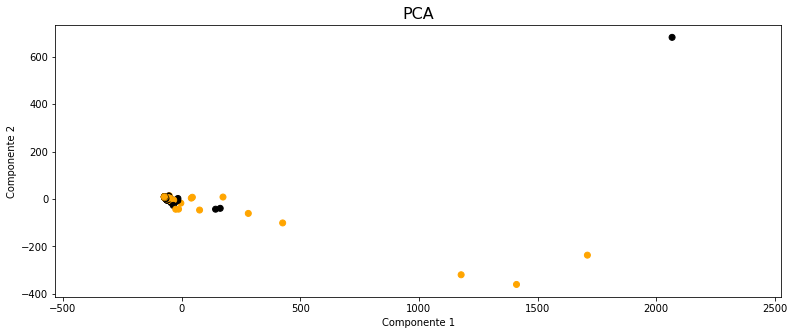

In [43]:
colors = ["black", "orange"]
plt.close('all')


plt.figure(figsize=(13,5))
plt.scatter(X_pca_train[:,0],X_pca_train[:,1], c=colors)
plt.axis('equal')
plt.title("PCA", size=16)
plt.ylabel("Componente 2")
plt.xlabel("Componente 1")
plt.show()

> k) Entrene un modelo de Regresión Logı́stica variando el parámetro de regularización $C$ construyendo un gráfico resumen del error en función de este hiper-parámetro. Además entrene un Perceptrón, variando el hiper-parámetro de regularización $\alpha$ en el rango inverso que para la Regresión Logı́stica ¿Por qué? Contruya el mismo gráfico resumen, en función de $C$ o $\alpha$. Compare y comente lo observado.

La librería sklearn define **C** como $C = \frac{1}{\lambda}$, siendo $\lambda$ el parametro de regularización de la norma l2. Luego, como el Perceptrón ocupa $\lambda$ como parámetro de regularizacion, se usa $\alpha = \frac{1}{C}$

In [29]:
Cs = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alphas = [1/c for c in Cs]

erroresTrainLogisticPCA = []
erroresTestLogisticPCA = []
erroresTrainPerceptronPCA = []
erroresTestPerceptronPCA = []


################### Regresion Logistica #########################
for c in Cs:
    modelLogistic = LogisticRegression(penalty='l2', C=c, max_iter=200)
    modelLogistic.fit(X_pca_train, y_train)
    erroresTrainLogisticPCA.append(1 - modelLogistic.score(X_pca_train,y_train))
    erroresTestLogisticPCA.append(1 - modelLogistic.score(X_pca_test,y_test))
##################################################################

################### Perceptron #########################
for alpha in alphas:
    modelPerceptron = Perceptron(penalty='l2', alpha=alpha, max_iter=200)
    modelPerceptron.fit(X_pca_train, y_train) 
    erroresTrainPerceptronPCA.append(1 - modelPerceptron.score(X_pca_train,y_train))
    erroresTestPerceptronPCA.append(1 - modelPerceptron.score(X_pca_test,y_test))
##################################################################


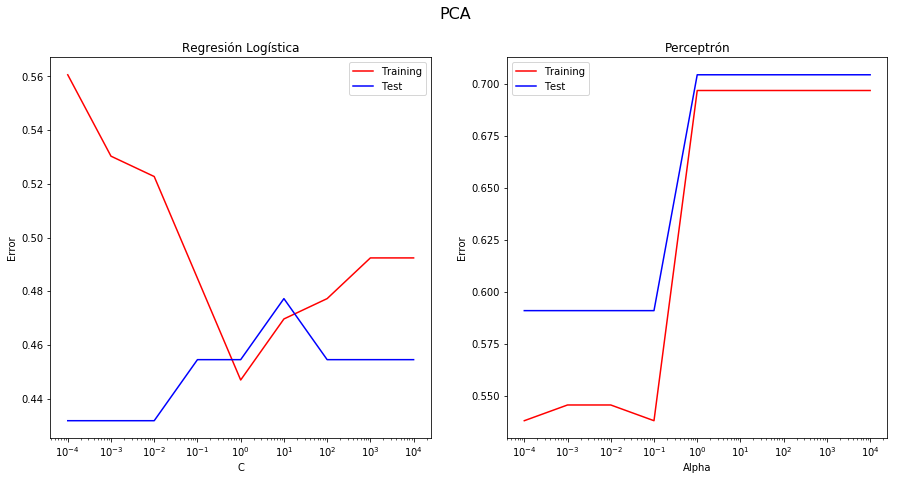

In [30]:
plt.close('all')

plt.figure(figsize=(15,7))
plt.suptitle("PCA", size=16)
plt.subplot(121)
ax = plt.gca()
ax.plot(Cs, erroresTrainLogisticPCA, color='red', label= 'Training')
ax.plot(Cs, erroresTestLogisticPCA, color='blue', label='Test')
ax.set_xscale('log')
plt.xlabel("C")
plt.ylabel("Error")
plt.title("Regresión Logística")
plt.legend(loc='best')


plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, erroresTrainPerceptronPCA, color='red', label= 'Training')
ax.plot(alphas, erroresTestPerceptronPCA, color='blue', label='Test')
#ax.plot(Cs, erroresTrainPerceptronPCA, color='red', label= 'Training')
#ax.plot(Cs, erroresTestPerceptronPCA, color='blue', label='Test')
ax.set_xscale('log')
plt.xlabel("Alpha")
#plt.xlabel("C")
plt.ylabel("Error")
plt.title("Perceptrón")
plt.legend(loc='best')

plt.show()

Para el modelo de regresión logística, un valor **C** pequeño implica una mayor regularizacion, por lo que el modelo resultante es más simple. Esto queda en evidencia con la diferencia entre el error de training y el de test.

En el caso del Perceptrón, para un **C** pequeño ($\alpha$ grande) se observa una menor diferencia entre el error de training y el de test.

En general, el Perceptrón tiene un error mayor en ambos casos.

> l) Genere otra representación de los datos a través de la técnica de reducción de dimensionalidad **ICA**, con dimensionalidad $d = 2$. Recuerde que sólo se debe ajustar con el conjunto de entrenamiento, si se muestra un *warning* explique el porqué. Visualice apropiadamente la proyección en 2 dimensiones. Vuelva a realizar el item k) pero para esta nueva representación.

In [31]:
ica_model = FastICA(n_components=d)
ica_model.fit(X_train)
X_ica_train = ica_model.transform(X_train)
X_ica_test = ica_model.transform(X_test)

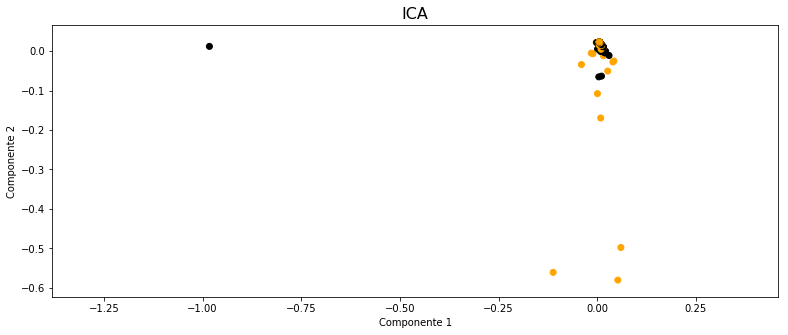

In [32]:
colors = ["black", "orange"]
plt.close('all')

plt.figure(figsize=(13,5))
plt.scatter(X_ica_train[:,0],X_ica_train[:,1], c=colors)
plt.axis('equal')
plt.title("ICA", size=16)
plt.ylabel("Componente 2")
plt.xlabel("Componente 1")
plt.show()

In [33]:
erroresTrainLogisticICA = []
erroresTestLogisticICA = []
erroresTrainPerceptronICA = []
erroresTestPerceptronICA = []


################### Regresion Logistica #########################
for c in Cs:
    modelLogistic = LogisticRegression(penalty='l2', C=c, max_iter=200)
    modelLogistic.fit(X_ica_train, y_train)
    erroresTrainLogisticICA.append(1 - modelLogistic.score(X_ica_train,y_train))
    erroresTestLogisticICA.append(1 - modelLogistic.score(X_ica_test,y_test))
##################################################################

################### Perceptron #########################
for alpha in alphas:
    modelPerceptron = Perceptron(penalty='l2', alpha=alpha, max_iter=200)
    modelPerceptron.fit(X_ica_train, y_train) 
    erroresTrainPerceptronICA.append(1 - modelPerceptron.score(X_ica_train,y_train))
    erroresTestPerceptronICA.append(1 - modelPerceptron.score(X_ica_test,y_test))
##################################################################

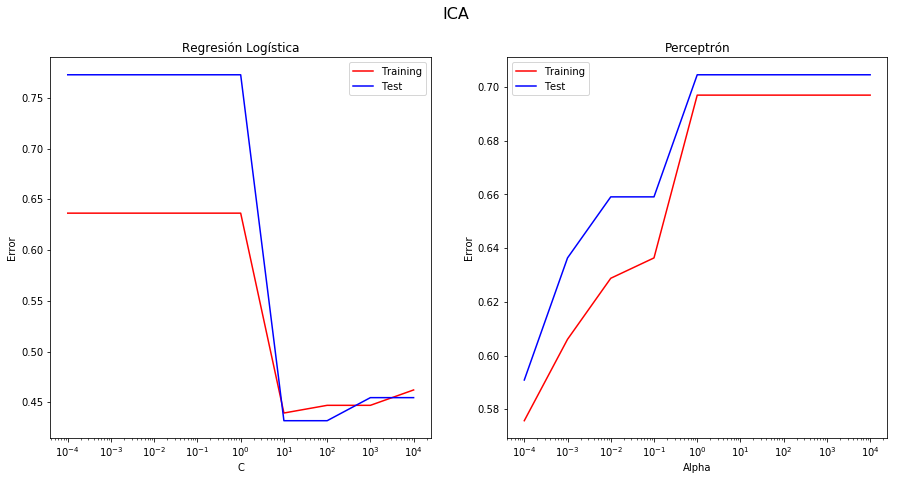

In [34]:
plt.close('all')

plt.figure(figsize=(15,7))
plt.suptitle("ICA", size=16)
plt.subplot(121)
ax = plt.gca()
ax.plot(Cs, erroresTrainLogisticICA, color='red', label= 'Training')
ax.plot(Cs, erroresTestLogisticICA, color='blue', label='Test')
ax.set_xscale('log')
plt.xlabel("C")
plt.ylabel("Error")
plt.title("Regresión Logística")
plt.legend(loc='best')


plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, erroresTrainPerceptronICA, color='red', label= 'Training')
ax.plot(alphas, erroresTestPerceptronICA, color='blue', label='Test')
#ax.plot(Cs, erroresTrainPerceptronICA, color='red', label= 'Training')
#ax.plot(Cs, erroresTestPerceptronICA, color='blue', label='Test')
ax.set_xscale('log')
plt.xlabel("Alpha")
#plt.xlabel("C")
plt.ylabel("Error")
plt.title("Perceptrón")
plt.legend(loc='best')

plt.show()

A diferencia de la regresión logística usando PCA, con ICA se observa que tanto el error training como el de test se comportan de forma similar respecto a la variación de **C**. Lo mismo ocurre para el caso del Perceptrón.

Otra cosa interesante es que en ambos casos una menor regularización disminuye ambos errores sin producir una diferencia significativa entre ellos.

> m) Experimente con diferentes dimensiones $d$ para la proyección de PCA e ICA con el propósito de obtener un modelo con menor error. Construya una tabla o gráfico resumen de los errores o *accuracy*, comente.

Se realizarán los procedimientos usando como dimensiones los valores 5, 10 y 20. A continuación, se obtienen los errores para cada dimensión e hiper-parámetro.

In [35]:
start = time.time()

dimensiones = [5, 10, 20]
i = 0

##Lista de lista donde se almacenan los errores de cada modelo para cada dimension. 
##Cada elemento de la lista principal representa una dimension
##Cada sub-lista contiene los errores de los modelos para cada C/Alpha para la dimension correspondiente
erroresTrainLogisticPCA_MultiD = [[], [], []]
erroresTestLogisticPCA_MultiD = [[], [], []]
erroresTrainPerceptronPCA_MultiD = [[], [], []]
erroresTestPerceptronPCA_MultiD = [[], [], []]

erroresTrainLogisticICA_MultiD = [[], [], []]
erroresTestLogisticICA_MultiD = [[], [], []]
erroresTrainPerceptronICA_MultiD = [[], [], []]
erroresTestPerceptronICA_MultiD = [[], [], []]
###################################################################################################

##Se generan los modelos y se calculan los errores
for dim in dimensiones: 
    pca_model_MultiD = PCA(n_components = dim)
    pca_model_MultiD.fit(X_train)
        
    ica_model_MultiD = FastICA(n_components=dim)
    ica_model_MultiD.fit(X_train)
    
    #Se aplica una reduccion usando PCA con la dimension correspondiente
    X_pca_train_MultiD = pca_model_MultiD.transform(X_train)
    X_pca_test_MultiD = pca_model_MultiD.transform(X_test)
        
    #Se aplica una reduccion usando ICA con la dimension correspondiente    
    X_ica_train_MultiD = ica_model_MultiD.transform(X_train)
    X_ica_test_MultiD = ica_model_MultiD.transform(X_test)    
    
    #Se entrenan los modelos de regresion logistica y se calculan los errores para cada C, se añaden a la lista "errores[i][]"
    ########## Regresión logística ####################################
    for c in Cs:    
        modelLogisticPCA_MultiD = LogisticRegression(penalty='l2', C=c, max_iter=200)
        modelLogisticPCA_MultiD.fit(X_pca_train_MultiD, y_train) ##PCA
        
        modelLogisticICA_MultiD = LogisticRegression(penalty='l2', C=c, max_iter=200)
        modelLogisticICA_MultiD.fit(X_ica_train_MultiD, y_train) ##ICA
        
        ##PCA
        erroresTrainLogisticPCA_MultiD[i].append(1 - modelLogisticPCA_MultiD.score(X_pca_train_MultiD,y_train))
        erroresTestLogisticPCA_MultiD[i].append(1 - modelLogisticPCA_MultiD.score(X_pca_test_MultiD,y_test))
        
        ##ICA
        erroresTrainLogisticICA_MultiD[i].append(1 - modelLogisticICA_MultiD.score(X_ica_train_MultiD,y_train))
        erroresTestLogisticICA_MultiD[i].append(1 - modelLogisticICA_MultiD.score(X_ica_test_MultiD,y_test))
    #######################################################################################################  
    
    
    #Se entrenan los Perceptrones y se calculan los errores para cada alpha, se añaden a la lista "errores[i][]"
    ############### Perceptrón ###########################################
    for alpha in alphas:
        modelPerceptronPCA_MultiD = Perceptron(penalty='l2', alpha=alpha, max_iter=200)
        modelPerceptronPCA_MultiD.fit(X_pca_train_MultiD, y_train) ##PCA
        
        modelPerceptronICA_MultiD = Perceptron(penalty='l2', alpha=alpha, max_iter=200)
        modelPerceptronICA_MultiD.fit(X_ica_train_MultiD, y_train) ##ICA
        
        ##PCA
        erroresTrainPerceptronPCA_MultiD[i].append(1 - modelPerceptronPCA_MultiD.score(X_pca_train_MultiD,y_train))
        erroresTestPerceptronPCA_MultiD[i].append(1 - modelPerceptronPCA_MultiD.score(X_pca_test_MultiD,y_test))
        
        ##ICA
        erroresTrainPerceptronICA_MultiD[i].append(1 - modelPerceptronICA_MultiD.score(X_ica_train_MultiD,y_train))
        erroresTestPerceptronICA_MultiD[i].append(1 - modelPerceptronICA_MultiD.score(X_ica_test_MultiD,y_test))
    i+=1
    
print("Tiempo que tarda en ejecutarse:", round(time.time()-start, 1), "segundos")    

Tiempo que tarda en ejecutarse: 8.0 segundos


Luego, se grafican los errores en función de los hiper-parámetros C/Alpha para poder visualizar el efecto que ocurre al aumentar la dimensión.

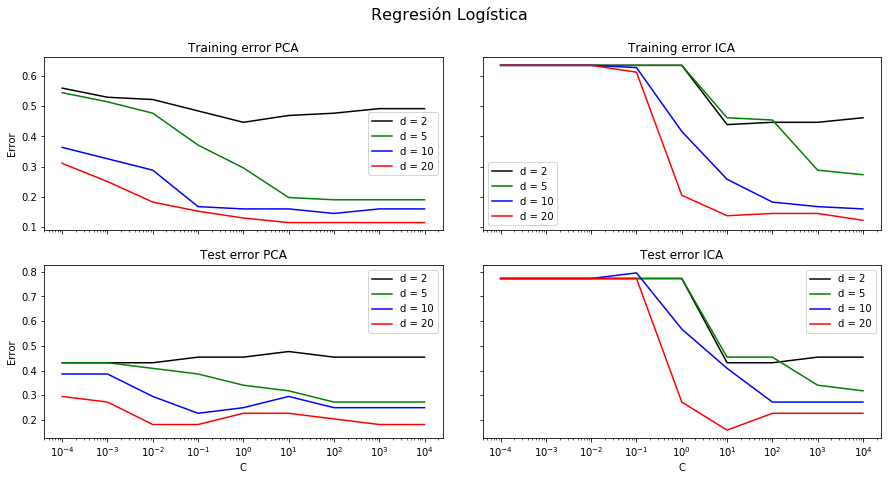

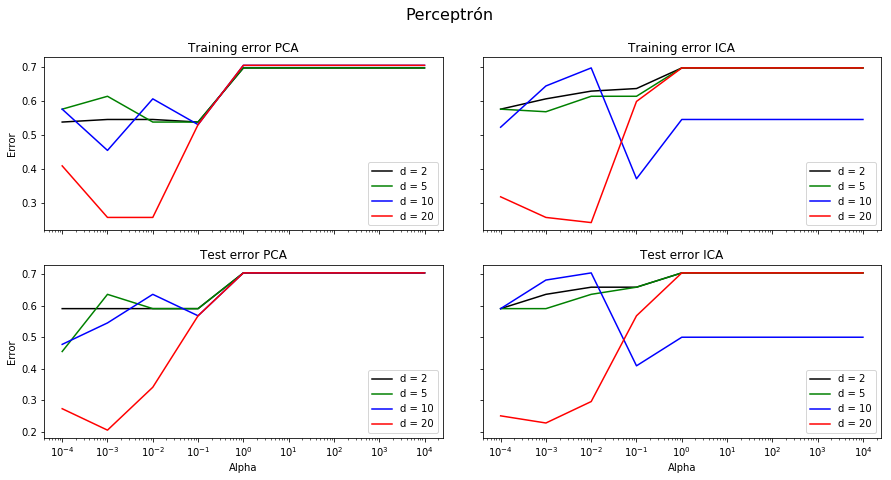

In [36]:
plt.close('all')

##################### Regresión Logística ########################
fig1, ax1 = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15,7), num=1)
fig1.subplots_adjust(hspace=0.2, wspace=0.1)

fig1.suptitle("Regresión Logística", size=16)

for i in range(2):
    for j in range(2):
        ax1[i,j].set_xscale('log')
        
for item in ax1.flat:
    item.set(xlabel='C', ylabel='Error')
    item.label_outer()
      
ax1[0,0].title.set_text("Training error PCA")
ax1[0,1].title.set_text("Training error ICA")
ax1[1,0].title.set_text("Test error PCA")
ax1[1,1].title.set_text("Test error ICA")

ax1[0,0].plot(Cs, erroresTrainLogisticPCA, color='black', label= 'd = 2')
ax1[0,0].plot(Cs, erroresTrainLogisticPCA_MultiD[0], color='green', label= 'd = 5')
ax1[0,0].plot(Cs, erroresTrainLogisticPCA_MultiD[1], color='blue', label= 'd = 10')
ax1[0,0].plot(Cs, erroresTrainLogisticPCA_MultiD[2], color='red', label= 'd = 20')

ax1[0,1].plot(Cs, erroresTrainLogisticICA, color='black', label= 'd = 2')
ax1[0,1].plot(Cs, erroresTrainLogisticICA_MultiD[0], color='green', label= 'd = 5')
ax1[0,1].plot(Cs, erroresTrainLogisticICA_MultiD[1], color='blue', label= 'd = 10')
ax1[0,1].plot(Cs, erroresTrainLogisticICA_MultiD[2], color='red', label= 'd = 20')

ax1[1,0].plot(Cs, erroresTestLogisticPCA, color='black', label= 'd = 2')
ax1[1,0].plot(Cs, erroresTestLogisticPCA_MultiD[0], color='green', label= 'd = 5')
ax1[1,0].plot(Cs, erroresTestLogisticPCA_MultiD[1], color='blue', label= 'd = 10')
ax1[1,0].plot(Cs, erroresTestLogisticPCA_MultiD[2], color='red', label= 'd = 20')

ax1[1,1].plot(Cs, erroresTestLogisticICA, color='black', label= 'd = 2')
ax1[1,1].plot(Cs, erroresTestLogisticICA_MultiD[0], color='green', label= 'd = 5')
ax1[1,1].plot(Cs, erroresTestLogisticICA_MultiD[1], color='blue', label= 'd = 10')
ax1[1,1].plot(Cs, erroresTestLogisticICA_MultiD[2], color='red', label= 'd = 20')


ax1[0,0].legend(loc='best')
ax1[0,1].legend(loc='best')
ax1[1,0].legend(loc='best')
ax1[1,1].legend(loc='best')

##########################################################################


########################## Perceptrón #############################
fig2, ax2 = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15,7), num=2)
fig2.subplots_adjust(hspace=0.2, wspace=0.1)

fig2.suptitle("Perceptrón", size=16)
for i in range(2):
    for j in range(2):
        ax2[i,j].set_xscale('log')
        
for item in ax2.flat:
    item.set(xlabel='Alpha', ylabel='Error')
    item.label_outer()
        
ax2[0,0].title.set_text("Training error PCA")
ax2[0,1].title.set_text("Training error ICA")
ax2[1,0].title.set_text("Test error PCA")
ax2[1,1].title.set_text("Test error ICA")

ax2[0,0].plot(alphas, erroresTrainPerceptronPCA, color='black', label= 'd = 2')
ax2[0,0].plot(alphas, erroresTrainPerceptronPCA_MultiD[0], color='green', label= 'd = 5')
ax2[0,0].plot(alphas, erroresTrainPerceptronPCA_MultiD[1], color='blue', label= 'd = 10')
ax2[0,0].plot(alphas, erroresTrainPerceptronPCA_MultiD[2], color='red', label= 'd = 20')

ax2[0,1].plot(alphas, erroresTrainPerceptronICA, color='black', label= 'd = 2')
ax2[0,1].plot(alphas, erroresTrainPerceptronICA_MultiD[0], color='green', label= 'd = 5')
ax2[0,1].plot(alphas, erroresTrainPerceptronICA_MultiD[1], color='blue', label= 'd = 10')
ax2[0,1].plot(alphas, erroresTrainPerceptronICA_MultiD[2], color='red', label= 'd = 20')

ax2[1,0].plot(alphas, erroresTestPerceptronPCA, color='black', label= 'd = 2')
ax2[1,0].plot(alphas, erroresTestPerceptronPCA_MultiD[0], color='green', label= 'd = 5')
ax2[1,0].plot(alphas, erroresTestPerceptronPCA_MultiD[1], color='blue', label= 'd = 10')
ax2[1,0].plot(alphas, erroresTestPerceptronPCA_MultiD[2], color='red', label= 'd = 20')

ax2[1,1].plot(alphas, erroresTestPerceptronICA, color='black', label= 'd = 2')
ax2[1,1].plot(alphas, erroresTestPerceptronICA_MultiD[0], color='green', label= 'd = 5')
ax2[1,1].plot(alphas, erroresTestPerceptronICA_MultiD[1], color='blue', label= 'd = 10')
ax2[1,1].plot(alphas, erroresTestPerceptronICA_MultiD[2], color='red', label= 'd = 20')

ax2[0,0].legend(loc='best')
ax2[0,1].legend(loc='best')
ax2[1,0].legend(loc='best')
ax2[1,1].legend(loc='best')

###############################################################################


El analisis se divide en 4 casos:
+ **Regresión Logística PCA**: Aumentar la dimensión disminuye el error de entrenamiento y test.
+ **Regresión Logística ICA**: Al igual que el caso anterior, aumentar la dimensión disminuye ambos errores, excepto cuando C se encuentra entre 1 y 100.
+ **Perceptrón PCA**: Para valores de alpha menores a 1, aumentar la dimensión disminuye ambos errores. Cuando alpha es mayor a 1, las dimensiones convergen a errores similares.
+ **Perceptrón ICA**: En general, el comportamiento es similar caso anterior, sin embargo, es curioso notar que a partir de cierto alpha conviene usar 10 dimensiones en vez de 20.

> n) Realice otra reducción de dimensionalidad ahora a través de la técnica **LDA**, para representar los datos en $d = 2$ dimensiones. Recuerde que sólo se debe ajustar con el conjunto de entrenamiento, si se muestra un *warning* explique el porqué. Visualice apropiadamente la proyección en 2 dimensiones.

In [37]:
lda_model = LDA(n_components=2)
lda_model.fit(X_train,y_train)
X_lda_train = lda_model.transform(X_train)
X_lda_test = lda_model.transform(X_test)

D:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


EL warning que se obtiene significa que las variables están relacionadas linealmente. Esto no es ideal debido a que LDA calcula una matriz de inversión, la cual pierde precisión si el determinante es cercano a 0 (2 o más variables relacionadas linealmente).

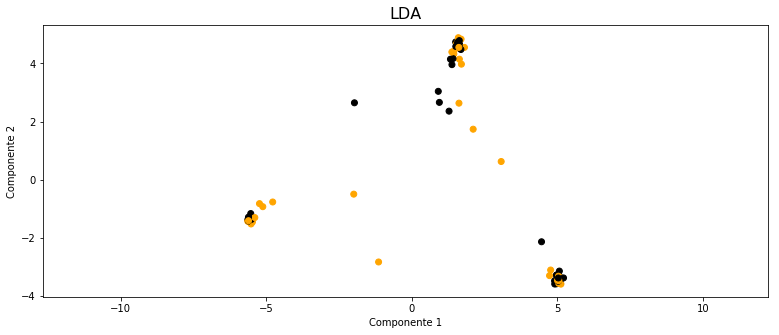

In [38]:
colors = ["black", "orange"]
plt.close('all')


plt.figure(figsize=(13,5))
plt.scatter(X_lda_train[:,0],X_lda_train[:,1], c=colors)
plt.axis('equal')
plt.title("LDA", size=16)
plt.ylabel("Componente 2")
plt.xlabel("Componente 1")
plt.show()

> o) Con el propósito de encontrar el mejor modelo vuelva a realizar el item k) en el nuevo espacio generado por la representación según las $d$ dimensiones de la proyección LDA. Esta nueva representación ¿mejora o empeora el desempeño? Explique.

In [39]:
erroresTrainLogisticLDA = []
erroresTestLogisticLDA = []
erroresTrainPerceptronLDA = []
erroresTestPerceptronLDA = []


################### Regresion Logistica #########################
for c in Cs:
    modelLogistic = LogisticRegression(penalty='l2', C=c, max_iter=200)
    modelLogistic.fit(X_lda_train, y_train)
    erroresTrainLogisticLDA.append(1 - modelLogistic.score(X_lda_train,y_train))
    erroresTestLogisticLDA.append(1 - modelLogistic.score(X_lda_test,y_test))
##################################################################

################### Perceptron #########################
for alpha in alphas:
    modelPerceptron = Perceptron(penalty='l2', alpha=alpha, max_iter=200)
    modelPerceptron.fit(X_lda_train, y_train) 
    erroresTrainPerceptronLDA.append(1 - modelPerceptron.score(X_lda_train,y_train))
    erroresTestPerceptronLDA.append(1 - modelPerceptron.score(X_lda_test,y_test))
##################################################################

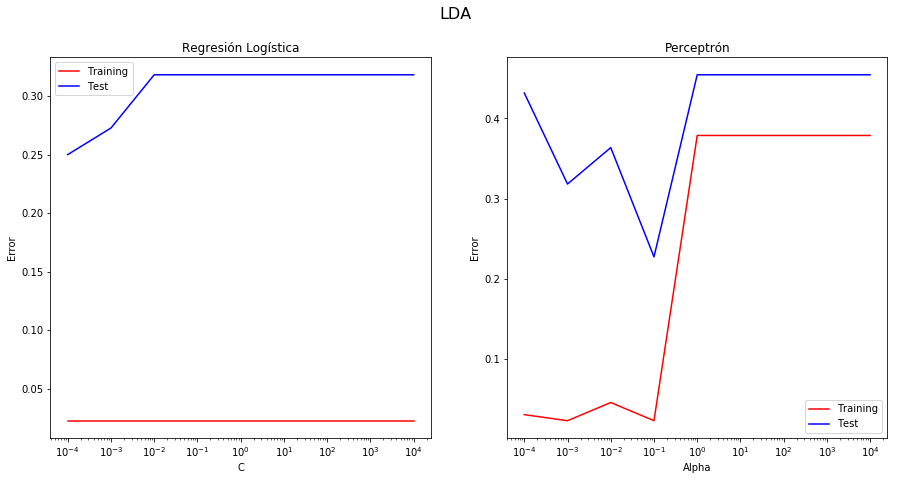

In [40]:
plt.close('all')

plt.figure(figsize=(15,7))
plt.suptitle("LDA", size=16)
plt.subplot(121)
ax = plt.gca()
ax.plot(Cs, erroresTrainLogisticLDA, color='red', label= 'Training')
ax.plot(Cs, erroresTestLogisticLDA, color='blue', label='Test')
ax.set_xscale('log')
plt.xlabel("C")
plt.ylabel("Error")
plt.title("Regresión Logística")
plt.legend(loc='best')


plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, erroresTrainPerceptronLDA, color='red', label= 'Training')
ax.plot(alphas, erroresTestPerceptronLDA, color='blue', label='Test')
ax.set_xscale('log')
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.title("Perceptrón")
plt.legend(loc='best')

plt.show()

Después de usar LDA se observa claramente una diferencia entre el error de training y de test en ambos modelos, por lo que podría estar produciendose overfitting.

> p) Intente mejorar el desempeño de los algoritmos ya entrenados. Diseñe ahora sus propias cracterı́sticas (*feature crafting*) a partir de los datos brutos (secuencia de amplitudes), puede inspirarse en otros trabajos, si desea.

No se pudo implementar lo requerido en este inciso.